In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:02<00:00, 36.7MB/s]
100% 2.13G/2.13G [01:02<00:00, 36.7MB/s]


In [ ]:
!ls

kaggle.json  leapgestrecog.zip	sample_data


In [ ]:
#Extracting the compressed dataset
from zipfile import  ZipFile

dataset = '/content/leapgestrecog.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is Extracted')

The dataset is Extracted


In [ ]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('/content/leapgestrecog/leapGestRecog/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'04_fist_moved': 0,
 '05_thumb': 1,
 '07_ok': 2,
 '06_index': 3,
 '01_palm': 4,
 '10_down': 5,
 '08_palm_moved': 6,
 '03_fist': 7,
 '02_l': 8,
 '09_c': 9}

In [ ]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll checking how many images are in the dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('/content/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('/content/leapgestrecog/leapGestRecog/0' +
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '/content/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1
            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

**Visualizing random samples from dataset**

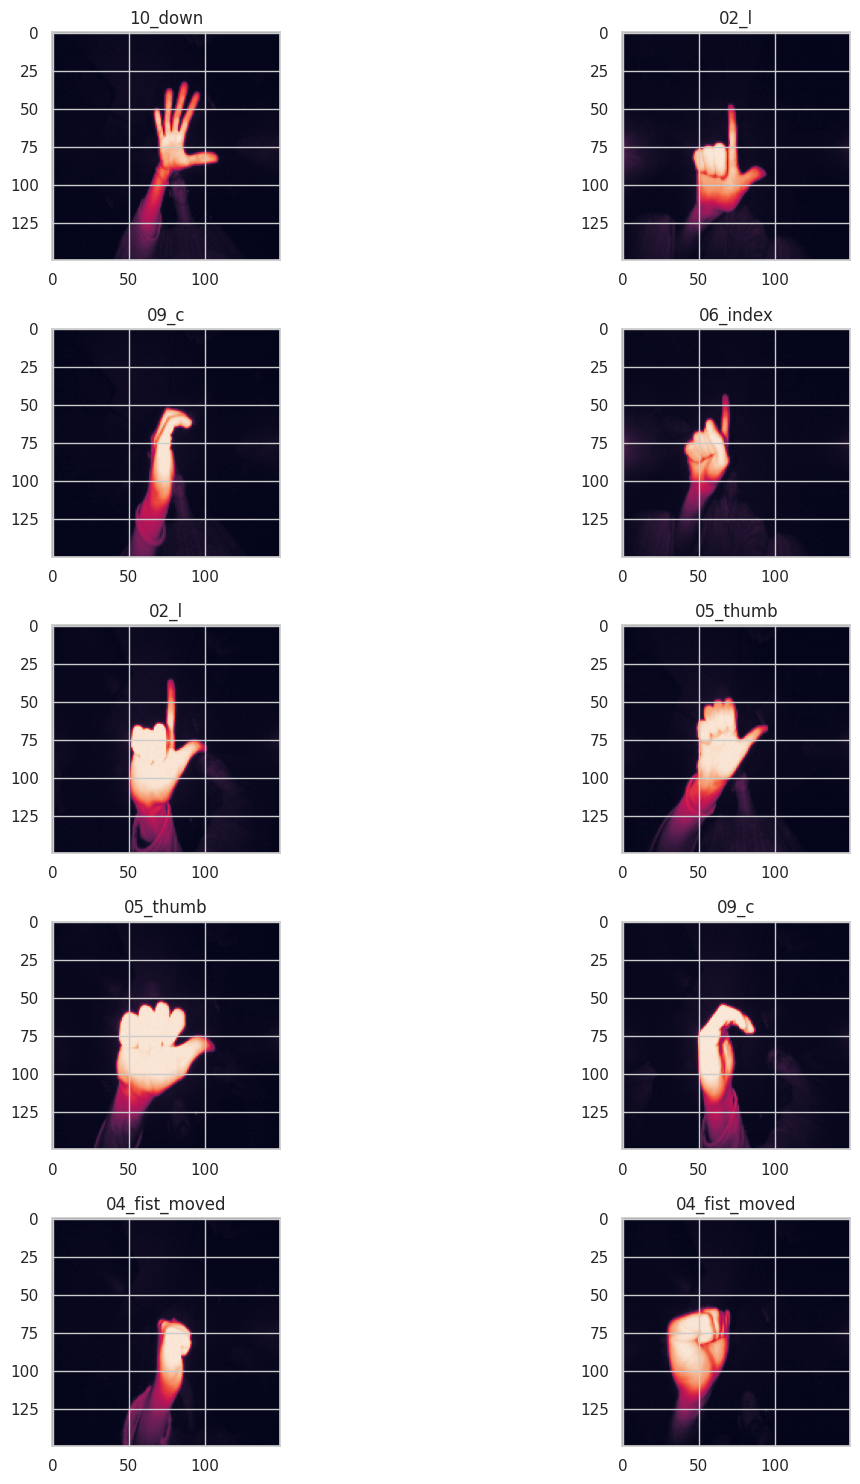

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])

plt.tight_layout()

Preprocessing the data
splitting into training and testing sets

In [ ]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

Building CNN Model

In [ ]:
CNN = Sequential()
CNN.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
CNN.add(MaxPooling2D(pool_size=(2,2)))


CNN.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


CNN.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

CNN.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

CNN.add(Flatten())
CNN.add(Dense(512))
CNN.add(Activation('relu'))
CNN.add(Dense(10, activation = "softmax"))

Seting Up Training Parameters


In [ ]:
batch_size=128
epochs=10

In [ ]:
checkpoint = ModelCheckpoint(
    './base.CNN',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

Compilation of model and Model summary Visualization

In [ ]:
CNN.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

Training the Model

In [ ]:
History = CNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8917
Epoch 1: val_loss improved from inf to 0.01037, saving model to ./base.CNN
118/118 [==============================] - 961s 8s/step - loss: 0.3335 - accuracy: 0.8917 - val_loss: 0.0104 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9958
Epoch 2: val_loss improved from 0.01037 to 0.00497, saving model to ./base.CNN
118/118 [==============================] - 890s 8s/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0050 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9991
Epoch 3: val_loss improved from 0.00497 to 0.00307, saving model to ./base.CNN
118/118 [==============================] - 893s 8s/step - loss: 0.0018 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 4/10
118/118 [========================

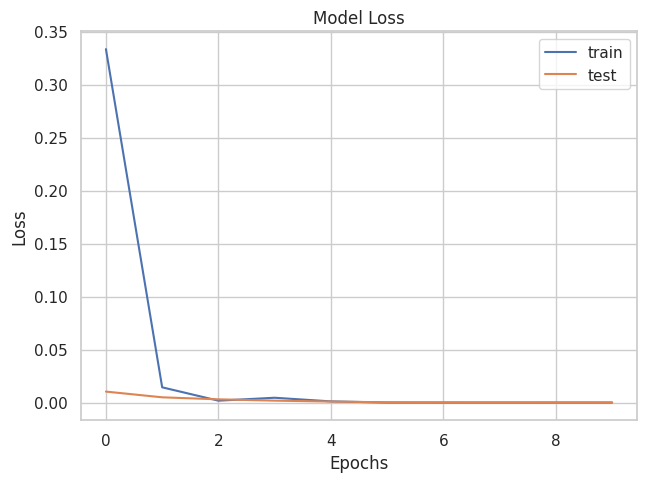

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Validation graph

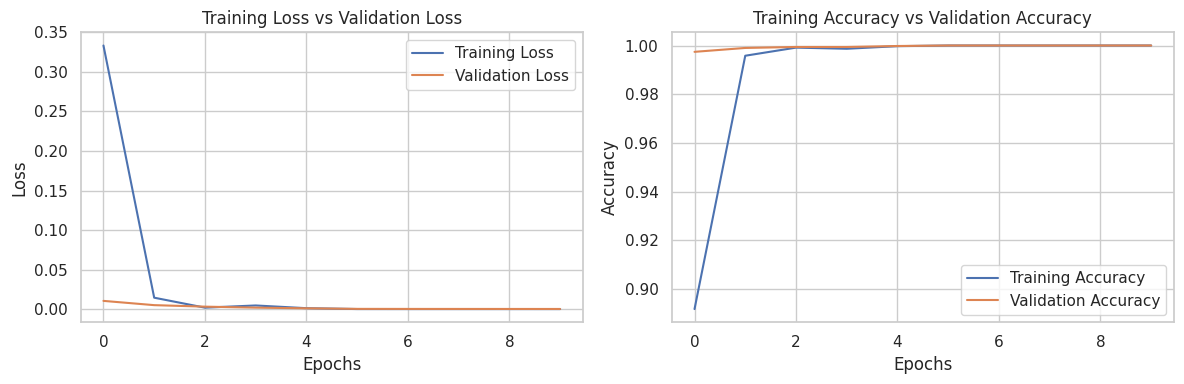

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Confidence Score

1/1 [==============================] - 0s 456ms/step


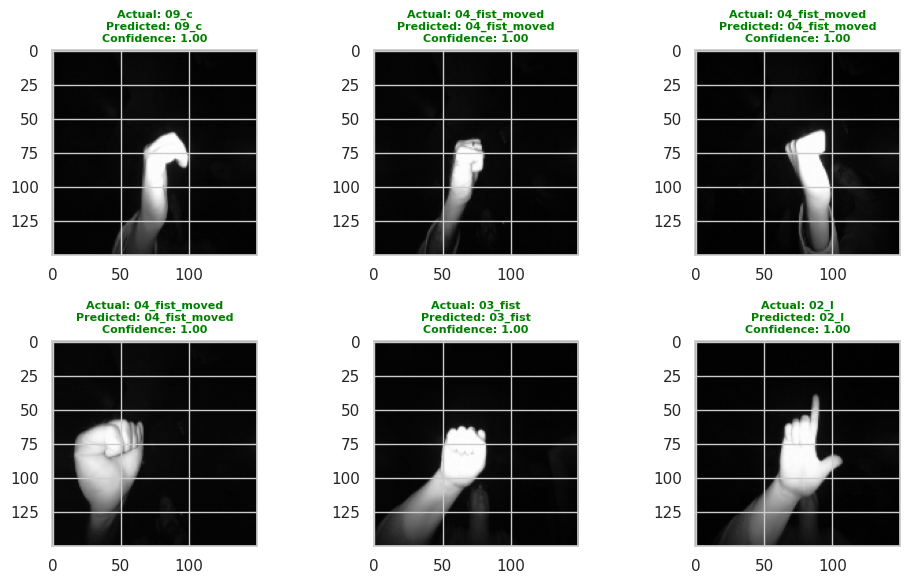

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = CNN.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = np.argmax(y_random_labels[index])
        confidence = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}\nConfidence: {confidence:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


Confusion Matrix

157/157 [==============================] - 80s 506ms/step


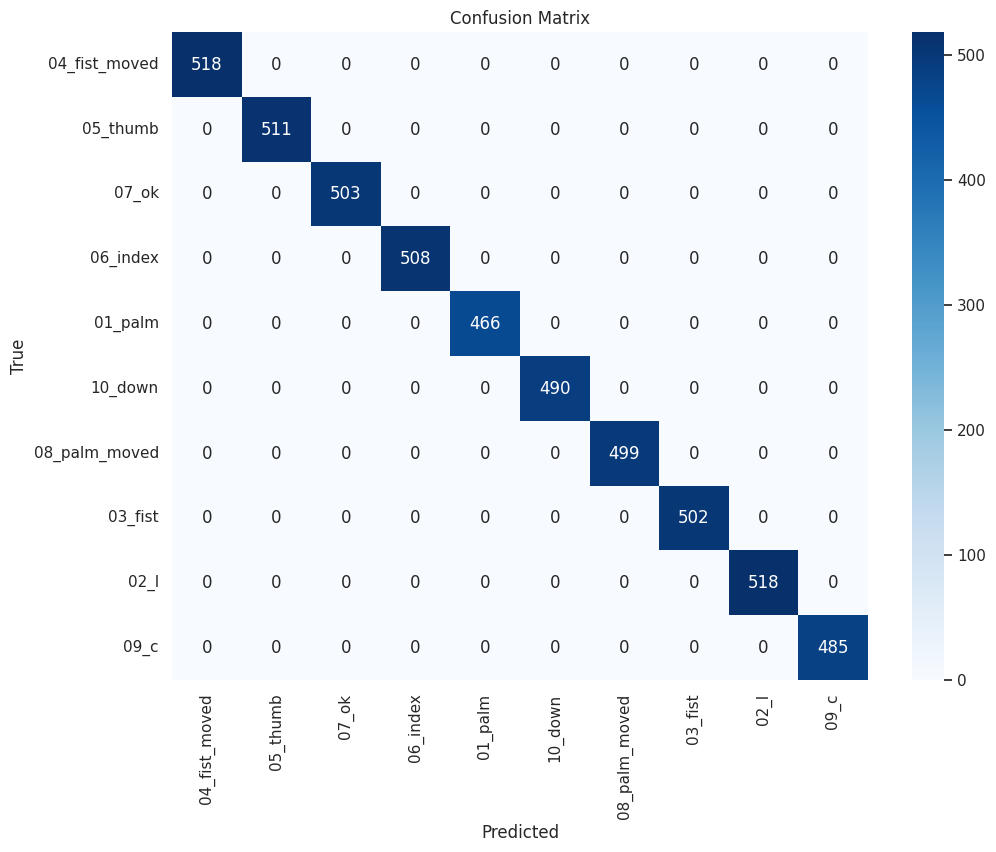

In [ ]:
y_pred = CNN.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()